In [17]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('fivethirtyeight')

from datetime import datetime
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings

warnings.filterwarnings("ignore")


## Importação de Arquivos

In [18]:
df_train = pd.read_csv('bases/train.csv')
df_test = pd.read_csv('bases/test.csv')
datasets = [df_train,df_test]

In [19]:
df_train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [20]:
dataset = df_train.append(df_test, ignore_index=True).drop('PassengerId', axis=1)
dataset.head(2)

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599


In [21]:
#df_train.drop(columns=['PassengerId','Ticket'], inplace=True)
#df_test.drop(columns=['Ticket'], inplace=True)


In [22]:
# def ticket_spliter(ticket):
#     if len(ticket.split(" ")) > 1:
#         return ticket.split(" ")[1][0]
#     else:
#         return ticket.split(" ")[0][0]


# for dataset in datasets:
#     dataset['Ticket'] = dataset['Ticket'].apply(lambda x : ticket_spliter(x))
    
print("For now we will not use Tickets")

For now we will not use Tickets


In [23]:
def treating_name_scalling(t_name):
    if t_name in ["Mr", "Miss", "Mrs","Master"]:
        return t_name
    else:
        return "Rare"


dataset['Treating_name'] = dataset['Name'].str.split(", ",expand=True)[1].str.split(".",expand=True)[0]  
dataset['Treating_name'] = dataset['Treating_name'].apply(lambda x : treating_name_scalling(x))
dataset.drop('Name', axis=1, inplace=True)

dataset.head(2)

,Age,Cabin,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Ticket,Treating_name
0,22.0,NaN,S,7.2500,0,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,71.2833,0,1,female,1,1.0,PC 17599,Mrs


In [24]:
def change_age(dataset, x):
    if np.isnan(x['Age']):
        age_mean = dataset.groupby('Treating_name').mean()[['Age']]
        return age_mean.loc[x['Treating_name']][0]
    else:
        return x['Age']

dataset['Age'] = dataset.apply(lambda x : change_age(dataset,x) , axis=1)
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].mean())
dataset.head(2)

,Age,Cabin,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Ticket,Treating_name
0,22.0,NaN,S,7.2500,0,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,71.2833,0,1,female,1,1.0,PC 17599,Mrs


In [25]:
dataset['Embarked'] = dataset['Embarked'].fillna("S")
dataset['Cabin'] = dataset['Cabin'].fillna("U")
dataset['Cabin'] = dataset['Cabin'].str[0]
    
dataset.head(2)

,Age,Cabin,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Ticket,Treating_name
0,22.0,U,S,7.2500,0,3,male,1,0.0,A/5 21171,Mr
1,38.0,C,C,71.2833,0,1,female,1,1.0,PC 17599,Mrs


In [26]:
dataset = dataset.drop('Ticket',axis=1)
dataset.head(2)

,Age,Cabin,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Treating_name
0,22.0,U,S,7.2500,0,3,male,1,0.0,Mr
1,38.0,C,C,71.2833,0,1,female,1,1.0,Mrs


In [27]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def columns_scaler(df, column):
    scaler = MinMaxScaler()
    end_size = len(df[column])
    scale_object = np.array(df[column]).reshape(-1,1)
    object_return = scaler.fit_transform(scale_object)
    return object_return.reshape(end_size,)


to_scale = ['Pclass', 'Age','SibSp','Parch','Fare']

for col in to_scale:
    dataset[col] = columns_scaler(dataset,col)

dataset.head(2)

,Age,Cabin,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Treating_name
0,0.273456,U,S,0.014151,0.0,1.0,male,0.125,0.0,Mr
1,0.473882,C,C,0.139136,0.0,0.0,female,0.125,1.0,Mrs


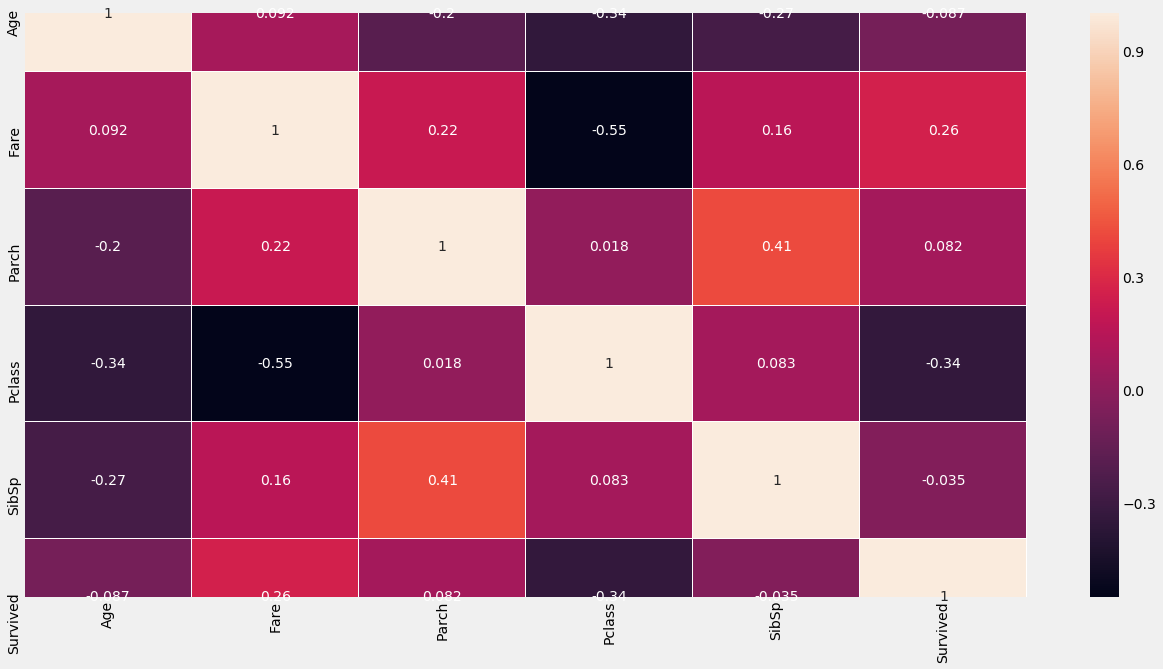

In [36]:
sns.heatmap(dataset[:len(df_train)].corr(), annot=True,linewidths=.05)
fig=plt.gcf()
fig.set_size_inches(20,10)

In [37]:
def encode_one_hot(df, column, axis=1):
    merged_df = df.join(pd.get_dummies(df[column], column)).drop(column, axis=axis) # Join
    merged_df = merged_df.drop(merged_df.columns[-1], axis=axis) # Take-off multicolinearity problems
    return merged_df

dummies_cols = ['Sex','Cabin','Embarked','Treating_name']


for col in dummies_cols:
    dataset = encode_one_hot(dataset,col)
print(f"Total de Colunas {dataset.columns}")
dataset.head(2)

Total de Colunas Index(['Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'Survived', 'Sex_female',
       'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_T', 'Embarked_C', 'Embarked_Q',
       'Treating_name_Master', 'Treating_name_Miss', 'Treating_name_Mr',
       'Treating_name_Mrs'],
      dtype='object')


,Age,Fare,Parch,Pclass,SibSp,Survived,Sex_female,Cabin_A,Cabin_B,Cabin_C,...,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Treating_name_Master,Treating_name_Miss,Treating_name_Mr,Treating_name_Mrs
0,0.273456,0.014151,0.0,1.0,0.125,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.473882,0.139136,0.0,0.0,0.125,1.0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1


In [38]:
# for dataset in datasets:
#     dataset['Age'] = pd.qcut(dataset['Age'],4 , labels=[0,1,2,3])
#     dataset['Fare'] = pd.qcut(dataset['Fare'],4, labels=[0,1,2,3])
#     dataset['Total Family'] = dataset['SibSp'] + dataset['Parch']
#     dataset['Alone'] = dataset['Total Family'] < 1
#     dataset['Alone'] = dataset['Alone'].astype(int)
print("Let´s check the results without this first")

Let´s check the results without this first


In [39]:
#x_cols = [cols for cols in df_train.columns if cols in df_test.columns]

x_train = dataset[:len(df_train)].drop('Survived', axis=1)

print("Nulos de cada dataframe:")
print(x_train.isnull().any().sum())

y_train = dataset[:len(df_train)]['Survived']
x_train.head(2)

Nulos de cada dataframe:
0


,Age,Fare,Parch,Pclass,SibSp,Sex_female,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Treating_name_Master,Treating_name_Miss,Treating_name_Mr,Treating_name_Mrs
0,0.273456,0.014151,0.0,1.0,0.125,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0.473882,0.139136,0.0,0.0,0.125,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1


In [40]:
x_test = dataset[len(df_train):].drop('Survived', axis=1)
x_test.head(2)

,Age,Fare,Parch,Pclass,SibSp,Sex_female,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Treating_name_Master,Treating_name_Miss,Treating_name_Mr,Treating_name_Mrs
891,0.430039,0.015282,0.0,1.0,0.000,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
892,0.586622,0.013663,0.0,1.0,0.125,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [41]:
!pip install tensorflow